# Week 13
# Deep Learning for Regression

So far, we have seen how neural networks are used for classification tasks, such as image classification, text classification, text generation. Today we will apply neural network model to a regression task.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


## Load Auto MPG Dataset

This dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/auto+mpg)

**Attribute Information**:

1. mpg: continuous
2. cylinders: multi-valued discrete
3. displacement: continuous
4. horsepower: continuous
5. weight: continuous
6. acceleration: continuous
7. model year: multi-valued discrete
8. origin: multi-valued discrete
9. car name: string (unique for each instance)

The goal of this project is to train a model that predicts "MPG" using other features.

In [2]:
# Load the dataset
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(url, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


## Data Preprocessing
- Check for missing values
- Handle categorical features
- Split into training and test set

In [3]:
# Are there any missing values?
# If so, how should we handle them?
dataset.isnull().sum()


MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

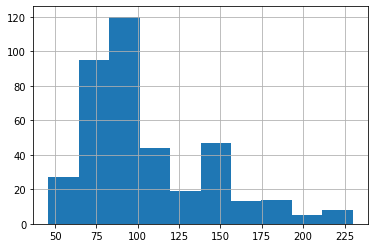

In [4]:
# Consider using mean or median to fill the missing values
dataset['Horsepower'].hist()
# Median is a better choice since the data is skewed
median = dataset['Horsepower'].median()
dataset['Horsepower'] = dataset['Horsepower'].fillna(median)

In [5]:
dataset.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [6]:
# The "Origin" column is really categorical, not numeric. 
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,USA
1,15.0,8,350.0,165.0,3693.0,11.5,70,USA
2,18.0,8,318.0,150.0,3436.0,11.0,70,USA
3,16.0,8,304.0,150.0,3433.0,12.0,70,USA
4,17.0,8,302.0,140.0,3449.0,10.5,70,USA


In [7]:
# Convert "Origin" to a one-hot vector:
# "USA" --> (0, 0, 1)
# "Europe" --> (0, 1, 0)
# "Japan" --> (1, 0, 0)
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


In [8]:
# Split the data into training set (80%) and test set (20%)
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(dataset, test_size=0.20)
print(df_train.shape, df_test.shape)

(318, 10) (80, 10)


## Inspect the Data
- Inspect the distribution of each individual feature:
    - descriptive statistics
    - histogram
- Inspect the relationship between features:
    - correlation coefficients
    - scatter plots

In [9]:
# Compute descriptive statistices: min, max, mean, median, standard deviation
df_train.describe()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
count,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000
mean,23.243396,5.465409,195.146226,104.885220,2985.616352,15.589623,75.877358,0.169811,0.188679,0.641509
std,7.639834,1.717528,105.250152,39.267346,856.822126,2.849592,3.688253,0.376059,0.391870,0.480313
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,17.500000,4.000000,105.500000,78.000000,2245.250000,14.000000,73.000000,0.000000,0.000000,0.000000
50%,22.450000,4.000000,146.000000,93.500000,2811.000000,15.500000,76.000000,0.000000,0.000000,1.000000
75%,28.000000,8.000000,293.250000,125.000000,3608.000000,17.275000,79.000000,0.000000,0.000000,1.000000
max,44.300000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


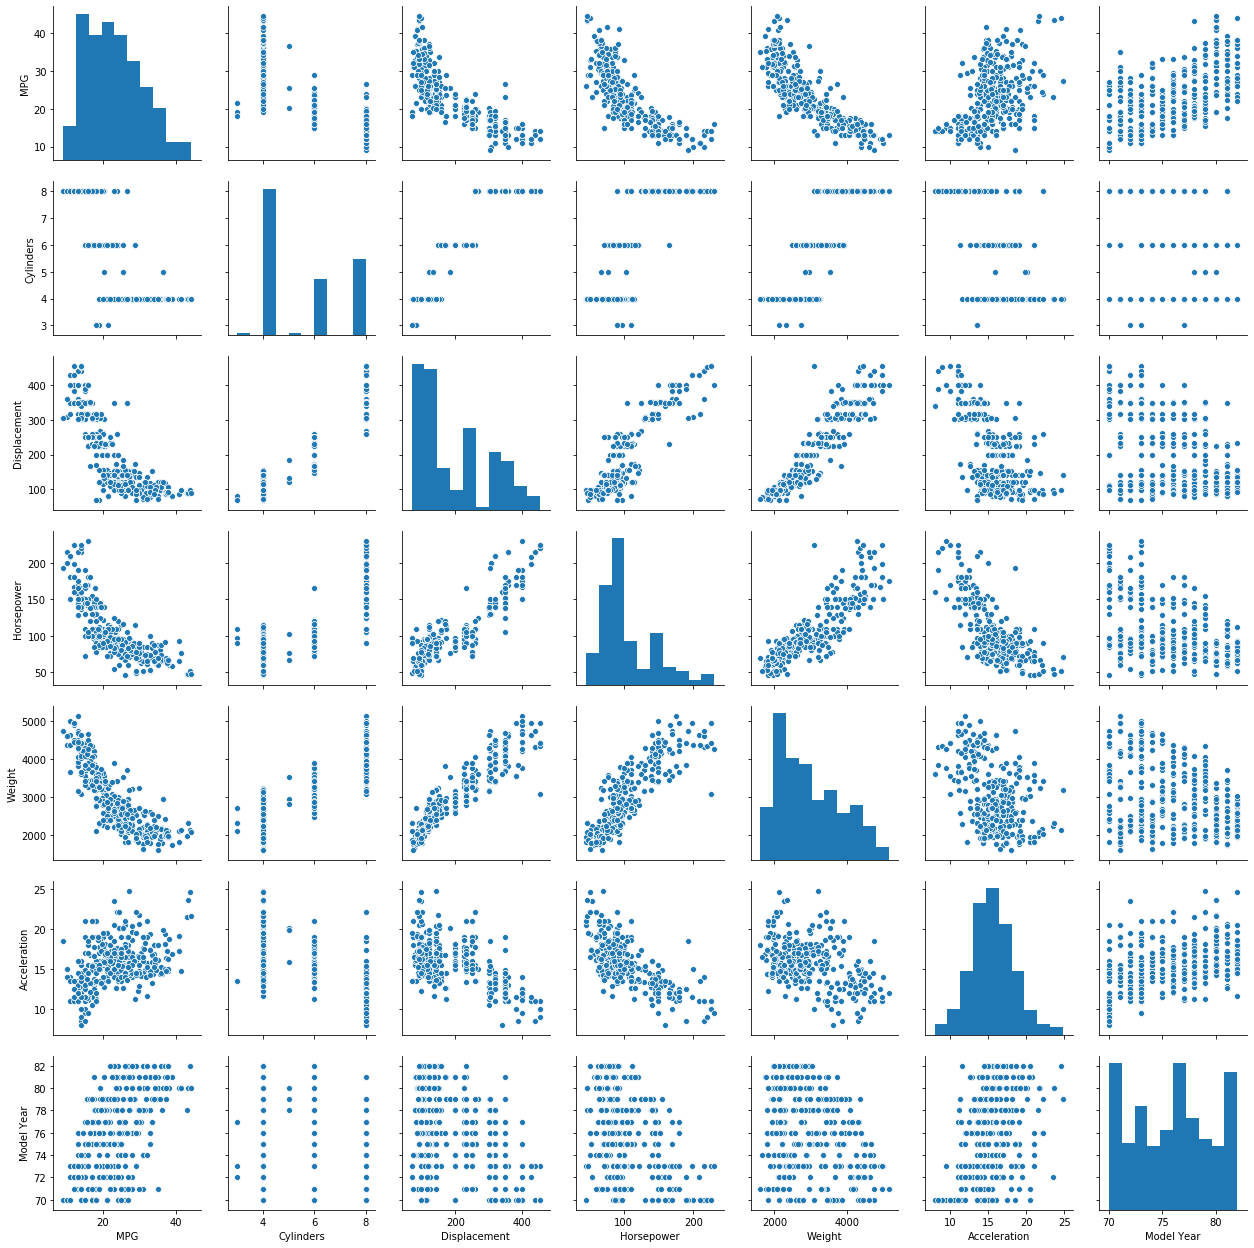

In [10]:
# Plot histogram and pairwise scatter plots for numerical variables
# pd.plotting.scatter_matrix(df_train, figsize=(15, 15))
# plt.show()

import seaborn as sns
sns.pairplot(df_train.iloc[:, :7])
# sns.pairplot(df_train.loc[:, ["MPG", "Cylinders", "Displacement", "Horsepower", "Weight",
#                               "Acceleration", "Model Year"]])

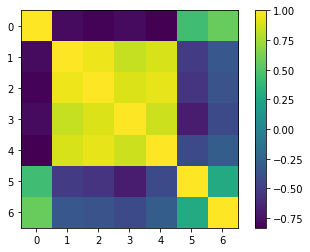

In [15]:
# Calculate the correlation coefficient between MPG and every other feature

plt.imshow(df_train.iloc[:, :7].corr())
plt.colorbar()

## Build the Model
- Transform data into proper format
- Normalize data
- Build neural network
- Specify loss function and training method

In [16]:
# Separate the "MPG" feature from the rest.
df_train_labels = df_train['MPG']
# df_train_data = df_train.loc[:, ['Cylinders', 'Displacement',...]]
df_train_data = df_train.iloc[:, 1:]
df_train_data.head()

df_test_labels = df_test['MPG']
df_test_data = df_test.iloc[:, 1:]
df_test_data.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
76,4,121.0,112.0,2933.0,14.5,72,1,0,0
292,8,360.0,150.0,3940.0,13.0,79,0,0,1
225,6,250.0,110.0,3520.0,16.4,77,0,0,1
354,4,100.0,93.5,2320.0,15.8,81,1,0,0
239,4,97.0,67.0,1985.0,16.4,77,0,1,0


In [17]:
# Normalize the data by applying the following tranformation:
# x <-- (x - mean) / std
# Result of this transform:
#   1. the average value of each column will be 0.
#   2. the standard deviation of each column will be 1.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_train_scaled = scaler.fit_transform(df_train_data)
df_train_scaled

array([[-0.8545526 , -0.42010203, -0.37967119, ..., -0.45226702,
        -0.48224282,  0.747545  ],
       [-0.8545526 , -0.92445789, -0.29039813, ..., -0.45226702,
        -0.48224282,  0.747545  ],
       [ 0.31174666,  0.59812583,  0.13046059, ..., -0.45226702,
        -0.48224282,  0.747545  ],
       ...,
       [-0.8545526 , -0.93397404, -0.68575025, ...,  2.21108319,
        -0.48224282, -1.33771211],
       [-0.8545526 , -1.17187774, -0.91530955, ..., -0.45226702,
         2.07364414, -1.33771211],
       [ 1.47804592,  1.94941887,  3.19125121, ..., -0.45226702,
        -0.48224282,  0.747545  ]])

In [19]:
np.mean(df_train_scaled, axis=0)

array([-2.01097001e-16,  5.16707571e-17,  2.79301390e-17, -1.56408778e-16,
       -1.22892612e-16, -2.20648098e-16,  2.79301390e-17,  0.00000000e+00,
        9.49624725e-17])

In [20]:
# If sklearn is not installed in the tensorflow environment, execute this command:
!pip install scikit-learn

You should consider upgrading via the 'c:\users\ch002\anaconda3\envs\tensorflow\python.exe -m pip install --upgrade pip' command.


In [28]:
# Build a 3-layer neural network:
# 1. input layer (what is the input shape?) 9
# 2. hidden layer with 64 nodes and ReLU activation
# 3. output layer (what is the output shape?) 1

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, input_shape=(9,), activation='relu'),
    tf.keras.layers.Dense(1)                                   
])


In [29]:
# Display a summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Use model.compile() to specify:
# 1. loss = 'mse'
# 2. optimizer = tf.keras.optimizers.RMSprop(0.001)
# 3. metrics = ['mae', 'mse']

model.compile(loss='mse',
              optimizer=tf.keras.optimizers.RMSprop(0.001),
              metrics=['mae', 'mse'])

## Train the Model
- Train the model
- Analyze the loss curve
- Improve the model

In [31]:
EPOCHS = 1000

history = model.fit(
  df_train_scaled, df_train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
)

In [32]:
# Visualize the model's training progress using the statistics stored in
# the "history" object
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,591.380300,23.171524,591.380310,568.353119,22.502632,568.353149,0
1,573.892300,22.805380,573.892334,553.724197,22.192526,553.724182,1
2,560.191868,22.517803,560.191895,540.427734,21.907166,540.427734,2
3,547.395953,22.242226,547.395996,527.787506,21.631023,527.787476,3
4,534.843340,21.966766,534.843384,515.060989,21.351845,515.060974,4


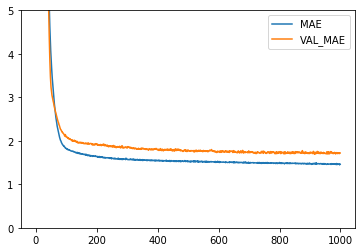

In [37]:
# Plot training MAE and validation MAE against epochs
plt.plot(hist['epoch'], hist['mae'], label='MAE')
plt.plot(hist['epoch'], hist['val_mae'], label='VAL_MAE')
plt.ylim([0, 5])
plt.legend()

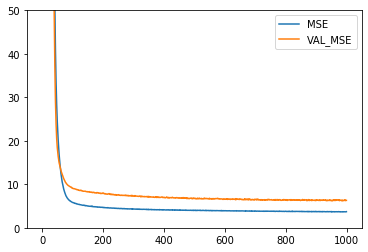

In [35]:
# Plot training MSE and validation MSE against epochs
plt.plot(hist['epoch'], hist['mse'], label='MSE')
plt.plot(hist['epoch'], hist['val_mse'], label='VAL_MSE')
plt.ylim([0, 50])
plt.legend()

In [ ]:
# Re-train the model with 100 epochs



## Evaluate the Model
- Evaluate the model on the test set
- Visualize the predictions

In [39]:
# Evalute the performance on the test set
df_test_scaled = scaler.transform(df_test_data) # scale the test set in the same way as the training set
model.evaluate(df_test_scaled, df_test_labels)

# MAE and MSE for test set is a bit too high, suggesting that this model is not optimally trained.

80/80 [==============================] - 0s 2ms/sample - loss: 12.4814 - mae: 2.3278 - mse: 12.4814


[12.481441879272461, 2.3278053, 12.481442]

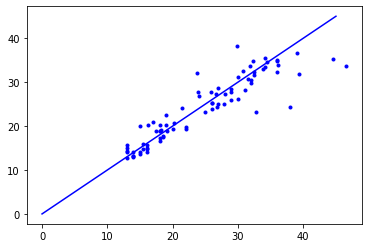

In [41]:
# Visualize model predictions against true values
test_predictions = model(df_test_scaled) # use model.predict if you are using TensorFlow 1
plt.plot(df_test_labels, test_predictions, 'b.')
plt.plot([0, 45], [0, 45], 'b-')


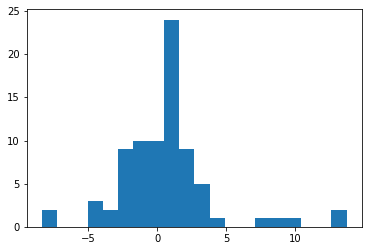

In [55]:
# Plot the histogram of prediction errors
plt.hist(df_test_labels.to_numpy() - test_predictions.numpy().reshape([-1]), bins=20)
plt.show()

In [54]:
df_test_labels.to_numpy() - test_predictions.numpy().reshape([-1])

array([-2.27284813,  0.87213135, -1.36129189, -0.03676987, -1.08115196,
        0.82011337,  9.27035294, -3.98018837,  1.18684006,  7.57735481,
        3.6630249 ,  0.42558403, 13.7645607 ,  1.88487434,  2.86320152,
        2.78694534, -3.89186249,  2.23433876,  0.1673193 ,  0.7580307 ,
       -0.89587975, -1.64826393,  3.11007881, -0.95406609,  1.79229546,
       -0.20633507,  1.20783806,  2.46261482,  1.18352127,  1.06005478,
       -1.98656578,  1.89981079,  0.83790588,  2.45001602, -8.35919113,
        0.02093735, -1.95156765,  0.60599518,  0.99572754,  1.43976021,
        0.76605988,  0.98600769,  0.81391716, -2.75961113,  0.77907467,
       -1.25365067,  2.17489014,  2.25702477, -4.08975105, -0.90637398,
        0.81075668, -2.65071106,  2.12003708, -1.42053452,  0.82242203,
       -2.44702072, -0.43225098,  0.48760796,  3.84234619, -4.92533112,
       -2.57757378,  0.69756889, -0.60888901,  0.29692554,  0.79491615,
       -8.34545975,  9.38759346, -3.46926689, -1.25445557,  1.41